In [2]:
import osiris_utils as ou
import numpy as np
from pathlib import Path
from tqdm import tqdm
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from scipy.signal import savgol_filter
import pandas as pd

from scipy.stats import linregress
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator,  FormatStrFormatter
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import contextlib
import io
import math

plt.rcParams['font.size'] = 14

In [3]:
def UtoV(u):
    return u / np.sqrt(1 + u**2)

def VtoU(v):
    return v * np.sqrt(1 - v**2)

def UtoGamma(u):
    return np.sqrt(1 + u**2)

In [4]:
def createSimDic(sim_labels, test):
    sim = {}
    for key in sim_labels.keys():
        sim[key] = {}
        for dtw in sim_labels[key]:
            sim[key][dtw] = ou.Simulation(f"/home/exxxx5/Tese/Decks/weibelTestsFinalV2/{test}/{key}/dtw{dtw}/{key}.in")
    return sim


def round_size(n):
    """Round n to 1 significant digit."""
    if n == 0:
        return 0
    return round(n, -int(math.floor(math.log10(n))))

def mean_rel_err_with_ar1(e):
    e = np.asarray(e)              # 1) Ensure e is a NumPy array (vector ops, speed, safety).
    N = e.size                     # 2) Number of time samples.

    if N < 2:                      # 3) If we have <2 points, we can't estimate variability.
        return float(e.mean()), np.nan

    em = e.mean()                  # 4) Sample mean: this is the point you will plot.
    x = e - em                     # 5) Mean-center the series (needed for variance & autocorr).
    s2 = x.var(ddof=1)             # 6) Sample variance of e_t (unbiased: ddof=1).

    # 7) Lag-1 autocorrelation ρ(1): similarity between consecutive samples.
    #    num = Σ (x_t * x_{t-1}); den = Σ (x_t^2). ρ(1) = num/den.
    num = np.dot(x[1:], x[:-1])
    den = np.dot(x, x)
    if (den == 0 or N < 3):
        rho1 = 0.0                 #    If constant or too short, assume no autocorrelation.
    else:
        rho1 = np.clip(num / den, -0.99, 0.99)  #    Clip for numerical stability.

    # 8) Effective sample size Neff for AR(1)-like correlation:
    #    With positive ρ(1), neighboring points carry redundant info, so Neff < N.
    Neff = N * (1 - rho1) / (1 + rho1)
    Neff = float(np.clip(Neff, 1.0, N))   #    Keep in [1, N] to avoid pathologies.

    # 9) Standard error of the mean using Neff (not naive N):
    #    SE( ē ) ≈ sqrt( s^2 / Neff ).
    se = np.sqrt(s2 / Neff)

    return float(em), float(se)

def find_nans_2d(a: np.ndarray):
    """
    Return locations and summary of NaNs in a 2D array.

    Returns dict with:
      - mask: boolean array, True where NaN
      - coords: (k,2) int array of [row, col] indices
      - rows: unique row indices containing NaN
      - cols: unique col indices containing NaN
      - count: total number of NaNs
    """
    a = np.asarray(a)
    if a.ndim != 2:
        raise ValueError("Input must be 2D")

    mask = np.isnan(a)
    count = int(mask.sum())
    if count:
        coords = np.argwhere(mask)
        rows = np.unique(coords[:, 0])
        cols = np.unique(coords[:, 1])
    else:
        coords = np.empty((0, 2), dtype=int)
        rows = np.array([], dtype=int)
        cols = np.array([], dtype=int)

    return dict(mask=mask, coords=coords, rows=rows, cols=cols, count=count)

In [5]:
def check_out_bounds(track):
    """
    Return rows of `track` that are outside the grid and a boolean flag
    indicating whether at least one particle is out of bounds.
    """
    mask = ((track['x1'] < track.grid[0, 0]) | (track['x1'] > track.grid[0, 1]) |
            (track['x2'] < track.grid[1, 0]) | (track['x2'] > track.grid[1, 1]) |
            (track['x3'] < track.grid[2, 0]) | (track['x3'] > track.grid[2, 1]))

    has_oob = bool(mask.any())
    return has_oob

In [6]:
# Normalize axis to w_ce

def _set_scaled_formatter(axis, scale_factor, fmt=".2f"):
    axis.set_major_formatter(
        FuncFormatter(lambda v, pos: f"{v*scale_factor:{fmt}}")
    )

def scale_x_ax(scale_factor, fig, ax, label=r"$t[1 / \Omega_p]$", lock_ticks=False, fmt=".2f"):
    ax.set_xlabel(label)
    if lock_ticks:
        # freeze current tick positions
        ticks = ax.get_xticks()
        ax.xaxis.set_major_locator(FixedLocator(ticks))
    _set_scaled_formatter(ax.xaxis, scale_factor, fmt)
    return fig, ax

def scale_y_ax(scale_factor, fig, ax, label=r"$x[c / \Omega_p]$", lock_ticks=False, fmt=".2f"):
    ax.set_ylabel(label)
    if lock_ticks:
        ticks = ax.get_yticks()
        ax.yaxis.set_major_locator(FixedLocator(ticks))
    _set_scaled_formatter(ax.yaxis, scale_factor, fmt)
    return fig, ax

def scale_z_ax(scale_factor, fig, ax, label=r"$x[c / \Omega_p]$", lock_ticks=False, fmt=".2f"):
    ax.set_zlabel(label)
    if lock_ticks:
        ticks = ax.get_zticks()
        ax.zaxis.set_major_locator(FixedLocator(ticks))
    _set_scaled_formatter(ax.zaxis, scale_factor, fmt)
    return fig, ax

def scale_3d_axes(scale_factor, fig, ax, fmt=".2f"):
    # ax.set_xlabel(r"$x_1[c / \Omega_e]$")
    # ax.set_ylabel(r"$x_2[c / \Omega_e]$")
    # ax.set_zlabel(r"$x_3[c / \Omega_e]$")
    _set_scaled_formatter(ax.xaxis, scale_factor, fmt)
    _set_scaled_formatter(ax.yaxis, scale_factor, fmt)
    _set_scaled_formatter(ax.zaxis, scale_factor, fmt)
    return fig, ax


In [7]:
def call_silently(func, *args, **kwargs):
    with contextlib.redirect_stdout(io.StringIO()):
        return func(*args, **kwargs)


def get_trajectory(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["x1"][particle, :][mask],
        track.data["x2"][particle, :][mask],
        track.data["x3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def plot_trajectory(sim, label, particle, tmin = 0, tmax = 100000000000, markersize=1.8, color = None, linewidth=0.8, linestyle='-', unload=False, fig=None, ax=None):
    traj = call_silently(get_trajectory, sim, particle, tmin, tmax)

    x, y, z, t = traj[0, :], traj[1, :], traj[2, :], traj[3, :]
    
    if fig is None:
        fig = plt.figure(figsize=(10, 7))

    label1 = None
    label2 = None
    if ax is None:
        ax = fig.add_subplot(111, projection='3d')
        # label1 = ("$t = {:.3f}$".format(t[0]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
        # label2 = ("$t = {:.3f}$".format(t[-1]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
        label1 = None
        label2 = None
    # Highlight start and end points
    ax.scatter(x[0], y[0], z[0], color='lightgreen', s=20, label=label1)
    ax.scatter(x[-1], y[-1], z[-1], color='r', s=20, label=label2)

    # Plot the trajectory
    ax.plot(x, y, z, marker='o', linestyle=linestyle, markersize=markersize, linewidth=linewidth, label=label, color=color)
    
    # Labels and title
    ax.set_xlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x1"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x1"]))
    ax.set_ylabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x2"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x2"]))
    ax.set_zlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["x3"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["x3"]))
    ax.legend()

    return fig, ax

In [8]:
def call_silently(func, *args, **kwargs):
    with contextlib.redirect_stdout(io.StringIO()):
        return func(*args, **kwargs)


def get_trajectory(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["x1"][particle, :][mask],
        track.data["x2"][particle, :][mask],
        track.data["x3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def get_p(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["p1"][particle, :][mask],
        track.data["p2"][particle, :][mask],
        track.data["p3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj


def get_fields(sim, particle, tmin = 0, tmax = 100000000000, unload=False):
    track = sim["test_electrons"]["tracks"]
    track.load_all()

    mask = (track.data["t"][particle, :] >= tmin) & (track.data["t"][particle, :] <= tmax)
    traj = np.stack([
        track.data["E1"][particle, :][mask],
        track.data["E2"][particle, :][mask],
        track.data["E3"][particle, :][mask],
        track.data["B1"][particle, :][mask],
        track.data["B2"][particle, :][mask],
        track.data["B3"][particle, :][mask],
        track.data["t"][particle, :][mask]
        ], axis=0)

    if unload:
        track.unload()

    return traj

def get_gradB(sim, t=None):
    
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    dB_x1 = ou.Derivative_Diagnostic(B, "x1")
    dB_x2 = ou.Derivative_Diagnostic(B, "x2")
    dB_x3 = ou.Derivative_Diagnostic(B, "x3")
    
    if isinstance(t, int):
        return np.stack([
            dB_x1[t],
            dB_x2[t],
            dB_x3[t]
        ], axis=0)
    else:
        return np.stack([
            dB_x1,
            dB_x2,
            dB_x3
        ], axis=0)

def get_b(sim, t=None):
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    b1 = sim_centered["part_b1"] / B
    b2 = sim_centered["part_b2"] / B
    b3 = sim_centered["part_b3"] / B

    b = np.stack([b1, b2, b3], axis=0)

    if isinstance(t, int):
        return b[t]
    else:
        return b
    
def get_Jacobian_b(sim, t=None):
    
    # Grid centered simulation
    sim_centered = ou.FieldCentering_Simulation(sim)

    B = (sim_centered["part_b1"]**2 + sim_centered["part_b2"]**2 + sim_centered["part_b3"]**2)**(0.5)

    b1 = sim_centered["part_b1"] / B
    b2 = sim_centered["part_b2"] / B
    b3 = sim_centered["part_b3"] / B

    J_B = np.empty((3, 3), dtype=object)
    for i, b_buffer in enumerate([b1, b2, b3]):
        for j, axis in enumerate(["x1", "x2", "x3"]):
            J_B[i,j] = ou.Derivative_Diagnostic(b_buffer, axis)

    if isinstance(t, int):
        return J_B[:, :, t]
    else:
        return J_B


def get_Jacobian_b_Interp(J_B, t=None):
    vfunc = np.vectorize(diag_interpolator, otypes=[object])
    return vfunc(J_B, t=t)


def diag_interpolator(diag, t=0):
    # TODO maybe considder periodic boundaries
    
    # Define grid points
    x = np.linspace(diag.grid[0][0] + diag.dx[0] / 2., diag.grid[0][1] - diag.dx[0] / 2., diag.nx[0])
    y = np.linspace(diag.grid[1][0] + diag.dx[1] / 2., diag.grid[1][1] - diag.dx[1] / 2., diag.nx[1])
    z = np.linspace(diag.grid[2][0] + diag.dx[2] / 2., diag.grid[2][1] - diag.dx[2] / 2., diag.nx[2])

    # return RegularGridInterpolator((x, y, z), diag[t], bounds_error=False, fill_value=None, method='cubic')
    return RegularGridInterpolator((x, y, z), diag[t], bounds_error=False, fill_value=None, method='linear')


def get_p_drift_savgol(p_perp, B, dt, n):
    Lfloat = 2. * np.pi / (B * dt) * n
    Lodd = (Lfloat.round().astype(int) // 2) * 2 + 1
    Lodd[Lodd < 5] = 5

    p_drift = np.empty_like(p_perp)

    breaks = np.flatnonzero(np.diff(Lodd)) + 1
    segments = np.concatenate(([0], breaks, [np.shape(p_perp)[1]]))

    for i0, i1 in zip(segments[:-1], segments[1:]):
        L = int(Lodd[i0])
        for comp in range(3):
            # Ensure window length does not exceed segment length
            window_length = min(L, i1 - i0)
            # Ensure polyorder is less than window_length
            polyorder = min(1, window_length - 1)  # polyorder should be less than window_length
            
            if window_length >= 3:  # Ensure window length is at least 3
                p_drift[comp, i0:i1] = savgol_filter(
                    p_perp[comp, i0:i1],
                    window_length=window_length,
                    polyorder=polyorder,
                    mode="interp"
                )
            else:
                print("Invalid window length for segment:", i0, i1, " Length:", i1 - i0)
                p_drift[comp, i0:i1] = p_perp[comp, i0:i1]  # Handle too short segment gracefully

    return p_drift


def plot_Ene(sim, label, fig=None, ax=None, unload=False):
    step = 100
    
    sim["test_electrons"]["tracks"].load_all()
    track = sim["test_electrons"]["tracks"]
    t = track["t"][0, ::step]

    if fig is None or ax is None:
        fig, ax = plt.subplots()

    Ene = np.average(track["ene"][:, ::step], axis = 0)
    ax.plot(t, Ene, label=label)
    ax.set_xlabel("${}$".format(track.labels["t"]) + "$[{}]$".format(track.units["t"]))
    ax.set_ylabel("${}$".format(track.labels["ene"]) + "$[{}]$".format(track.units["ene"]))

    if unload:
        track.unload()

    return fig, ax



def plot_drifts(sim, particles, tmin = 0, tmax = 100000000000, unload=False, fig=None, ax=None, n=1, rqm=-1):
    # plots non relativistic gca drifts along time

    gradB=get_gradB(sim)
    interp_gradB_1 = diag_interpolator(gradB[0], t=0)
    interp_gradB_2 = diag_interpolator(gradB[1], t=0)
    interp_gradB_3 = diag_interpolator(gradB[2], t=0)

    J_b = get_Jacobian_b(sim)
    J_b_Interp = get_Jacobian_b_Interp(J_b, t=0)
    
    v_EXB=[]
    v_GradB=[]
    v_c=[]
    v_v_EGrad_B=[]
    v_drif=[]
    v_gyr = []
    v_perp = []
    v_par = []
    v_total = []
    B_total = []
    E_total = []

    for particle in tqdm(particles, desc="Calculating Drifts"):
        # get x, p, E, B, t for the trajecotry of each particle
        fields = call_silently(get_fields, sim, particle, tmin, tmax)
        traj = call_silently(get_trajectory, sim, particle, tmin, tmax)
        p = call_silently(get_p, sim, particle, tmin, tmax)

        E = fields[0:3, :]
        B = fields[3:6, :]
        B_norm = np.linalg.norm(B, axis=0)
        b = B / B_norm
        b_B = b / B_norm
        t = fields[-1, :]
        dt = t[1]-t[0]

        # p parallel to b
        p_par = np.einsum('it, it->t', p[:3], b)
        #I think p is normalized with the mass of the particle so it is the same as u (no need to consider mass)
   
        p_perp = p[:3] - p_par * b
        v_perp.append(np.linalg.norm(p_perp, axis=0))
        v_par.append(np.abs(p_par))
        v_total.append(np.linalg.norm(p[:3], axis=0)) 


        # E x B drift
        v_EXB_vec = np.cross(E.T, b_B.T).T
        v_EXB.append(np.linalg.norm(v_EXB_vec, axis=0))

        

        # # p_perp drift
        # p_perp_drift_list = []
        # p_perp_g_list = []
        # mu_list = []
        
        # for i in range(20*n, len(t)-20*n):
        #     #Calculate B on the point = w_ce0
        #     B0 = np.linalg.norm(B[:, i])

        #     #Number of points in the same gyrocycle
        #     n_points = int(np.ceil(n* 2. * np.pi / (B0  * dt) ))

        #     # Calculate average B in selected points
        #     B_av_before = np.mean(np.linalg.norm(B[:, i-n_points+1 : i+1], axis=0))
        #     B_av_after = np.mean(np.linalg.norm(B[:, i+1 : i+n_points+1], axis=0))

        #     #Calculate better n_points
        #     n_points_before = int(np.ceil(n * 2. * np.pi / (B_av_before  * dt) ))
        #     n_points_after = int(np.ceil(n * 2. * np.pi / (B_av_after  * dt) ))

        #     # Calculate the drift velocity
        #     p_perp_drift = np.mean(p_perp[:, i-n_points_before+1 : i+n_points_after+1], axis=1)

        #     p_perp_g = np.linalg.norm(p_perp[:, i] - p_perp_drift)

        #     # print(n_points_before, n_points_after)
        #     # fig, ax = plt.subplots()
        #     # ax.plot(t[i-n_points_before+1 : i+n_points_after+1], np.linalg.norm(p_perp[:, i-n_points_before+1 : i+n_points_after+1], axis=0), label = "$p_{perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        #     # ax.scatter(t[i], np.linalg.norm(p_perp_drift), label="$p_{perp}^{drift}$")
        #     # ax.scatter(t[i], p_perp_g, label="$p_{perp}^{g}$")
        #     # ax.legend()
        #     # return fig, ax
        
        #     mu = p_perp_g**2 / (2. * B0)
        #     mu_list.append(mu)

        #     p_perp_drift_list.append(np.linalg.norm(p_perp_drift))
        #     p_perp_g_list.append(p_perp_g)



        # p_perp drift and p_perp_gyro
        p_perp_drift = get_p_drift_savgol(p_perp,  B_norm, dt, n)
        v_drif.append(np.linalg.norm(p_perp_drift, axis=0))

        p_perp_g = np.linalg.norm(p_perp - p_perp_drift, axis=0)
        mu_list = p_perp_g**2 / (2. * B_norm)
        v_gyr.append(p_perp_g)

        # fig, ax = plt.subplots()
        # # ax.plot(t, p_perp[0], label = r"$p_{\perp 1}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.plot(t, p_perp[1], label = r"$p_{\perp 2}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp[2], label = r"$p_{\perp 3}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp_drift[0], label = r"$p^{drift}_{\perp 1}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.plot(t, p_perp_drift[1], label = r"$p^{drift}_{\perp 2}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # # ax.plot(t, p_perp_drift[2], label = r"$p^{drift}_{\perp 3}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
        # ax.legend()
        # return fig, ax



        # GradB drift
        gradB_traj = np.stack([
            interp_gradB_1(traj[0:3].T),
            interp_gradB_2(traj[0:3].T),
            interp_gradB_3(traj[0:3].T)
        ], axis=0)

        v_GradB.append(np.linalg.norm(np.cross(b_B.T, gradB_traj.T), axis=1) * mu_list)


        # Interpolate jacobian of b
        J_b_traj = np.empty((3, 3, np.shape(t)[0]), dtype=float)
        for i in range(3):
            for j in range(3):
                J_b_traj[i,j] = J_b_Interp[i,j](traj[0:3].T)

        #Curvature drift: (b.Grad)b
        curvature = np.einsum('tj,tij->it', b.T, J_b_traj.transpose(2, 0, 1))

        vc_temp = rqm * (p_par**2)[:,None] * np.cross(b_B.T, curvature.T)
        v_c.append(np.linalg.norm(vc_temp, axis=1))


        # (v_E.Grad)b drift
        v_EGrad_B = np.einsum('tj,tij->it', v_EXB_vec.T, J_b_traj.transpose(2, 0, 1))
        v_v_EGrad_B_temp = rqm * (p_par)[:,None] * np.cross(b_B.T, v_EGrad_B.T)
        v_v_EGrad_B.append(np.linalg.norm(v_v_EGrad_B_temp, axis=1))

        B_total.append(B_norm)
        E_total.append(np.linalg.norm(E, axis=0))



    # fig, ax = plt.subplots(figsize=(10, 7))
    # ax.plot(t[20*n:-20],  np.linalg.norm(p_perp, axis = 0)[20*n:-20*n], label=r"$p_{\perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t[20*n:-20*n],  np.linalg.norm(p_perp_drift_list, axis=1), label=r"$p_{\perp}^{drift}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t[20*n:-20*n],  np.linalg.norm(p_perp_g_list, axis = 1), label=r"$p_{\perp}^{g}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.legend()
    # plt.show()
    
    if unload:
        sim["test_electrons"]["tracks"].unload()
        
    #average for every particle
    avrg_v_EXB = np.mean(np.array(v_EXB), axis=0)
    avrg_v_gradB = np.mean(np.array(v_GradB), axis=0)
    avrg_v_c = np.mean(np.array(v_c), axis=0)
    avrg_v_v_EGrad_B = np.mean(np.array(v_v_EGrad_B), axis=0)
    avrg_v_drift = np.mean(np.array(v_drif), axis=0)
    avrg_v_gyr = np.mean(np.array(v_gyr), axis=0)
    avrg_v_perp = np.mean(np.array(v_perp), axis=0)
    avrg_v_par = np.mean(np.array(v_par), axis=0)
    avrg_v_total = np.mean(np.array(v_total), axis=0)
    avrg_B = np.mean(np.array(B_total), axis=0)
    avrg_E = np.mean(np.array(E_total), axis=0)

    if fig is None:
        fig = plt.figure(figsize=(10, 7))

    if ax is None:
        ax = fig.add_subplot(111)

    ax.plot(t, avrg_v_total, label=r"$u$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_par, label=r"$u_{\parallel}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t, avrg_v_perp, label=r"$p_{perp}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # ax.plot(t, avrg_v_drift, label=r"$\langle p_{perp} \rangle$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    # ax.plot(t, avrg_v_EXB + avrg_v_gradB + avrg_v_c + avrg_v_v_EGrad_B, label=r"Drift Sum", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # ax.plot(t, avrg_v_gyr, label=r"$p_{gyr}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)


    ax.plot(t, avrg_v_EXB, label=r"$u_{\mathbf{E}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_gradB, label=r"$ u_{\nabla \mathbf{B}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_c, label=r"$u_{\mathbf{c}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)
    ax.plot(t, avrg_v_v_EGrad_B, label=r"$u_{\mathbf{E \nabla b}}$", marker='o', linestyle='-', markersize = 1.8, linewidth=1)

    # Labels and title
    ax.set_xlabel('${}$'.format(sim["test_electrons"]["tracks"].labels["t"]) + "$[{}]$".format(sim["test_electrons"]["tracks"].units["t"]))
    ax.set_ylabel('u' + "$[c]$")
    ax.legend()

    # EM fields
    # ax2 = ax.twinx()
    # ax2.plot(t, avrg_B, label=r"$B$", marker='o', linestyle='-', markersize = 1.8, linewidth=1, color = "black")

    # ax2.set_ylabel(f'$B [{sim["test_electrons"]["tracks"].units["B1"]}]$')
    # ax2.legend(loc='upper right')

    # ax3 = ax.twinx()
    # ax3.spines["right"].set_position(("axes", 1.3))
    # ax3.spines["right"].set_visible(True)

    # ax3.plot(t, avrg_E, label=r"$E$", marker='o', linestyle='-', markersize=1.8, linewidth=1, color="darkgray")
    # ax3.set_ylabel(f'$E [{sim["test_electrons"]["tracks"].units["E1"]}]$')
    # ax3.legend(loc='lower right')

    return fig, ax

In [9]:
def xRelErr(sim, baseline, particles=None,
            dtw_list=("100", "50", "10", "1", "0_1"),
            index_min=1, box_length=None, keepOutofBounds=False, pusherDashed=None):
    """
    Plot full-position relative distance error with periodic (cubic) box.
    Distances use the minimal-image convention and are normalized by L.
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # ---- helper to normalize 'particles' ----
    def _normalize_particles(sel, Np):
        if sel is None:
            return np.arange(Np, dtype=int)
        if isinstance(sel, slice):
            return np.arange(Np, dtype=int)[sel]
        arr = np.asarray(sel)
        if arr.dtype == bool:
            if arr.size != Np:
                raise ValueError(f"Boolean mask size {arr.size} != Np {Np}")
            return np.flatnonzero(arr)
        return np.atleast_1d(arr).astype(int)

    # ---- minimal-image delta under periodic BCs ----
    def _min_image(d, L):
        # maps differences to [-L/2, L/2] via nearest image
        return d - L * np.round(d / L)

    fig, ax = plt.subplots()

    # ---- read baseline once ----
    bx1_all = baseline["test_electrons"]["tracks"]["x1"]  # (Np, Tb)
    bx2_all = baseline["test_electrons"]["tracks"]["x2"]
    bx3_all = baseline["test_electrons"]["tracks"]["x3"]
    Np, Tb = bx1_all.shape

    part_idx = _normalize_particles(particles, Np)

    # try to infer box length L if not provided
    if box_length is None:
        L = baseline["test_electrons"]["tracks"].grid[0, 1] - baseline["test_electrons"]["tracks"].grid[0, 0]
    else:
        L = float(box_length)

    # trim baseline consistently
    bN = round_size(Tb) + 1
    bx1_all = bx1_all[:, :bN][part_idx]
    bx2_all = bx2_all[:, :bN][part_idx]
    bx3_all = bx3_all[:, :bN][part_idx]

    # init NaN trackers (counts among selected particles)
    nan_particle_count = {p: {dtw: 0 for dtw in sim[p]} for p in sim}
    nan_particle_list  = {p: {dtw: [] for dtw in sim[p]} for p in sim}

    for pusher in sim.keys():
        X, Y, YERR, YMax = [], [], [], []

        for dtw in dtw_list:
            step = max(1, int(float(dtw.replace("_", "."))))

            # baseline downsampled to match sim stride (vectorized)
            bx1 = bx1_all[:, step::step]
            bx2 = bx2_all[:, step::step]
            bx3 = bx3_all[:, step::step]

            # sim for all selected particles
            sx1_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x1"][part_idx]
            sx2_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x2"][part_idx]
            sx3_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x3"][part_idx]

            # trim sim and apply index_min
            Ts = sx1_all.shape[1]
            sN = round_size(Ts) + 1
            sx1 = sx1_all[:, index_min:sN]
            sx2 = sx2_all[:, index_min:sN]
            sx3 = sx3_all[:, index_min:sN]

            # ensure equal time length
            Ltime = min(bx1.shape[1], sx1.shape[1])
            if Ltime <= 0:
                continue
            bx1, bx2, bx3 = bx1[:, :Ltime], bx2[:, :Ltime], bx3[:, :Ltime]
            sx1, sx2, sx3 = sx1[:, :Ltime], sx2[:, :Ltime], sx3[:, :Ltime]

            bad = (
                np.isnan(sx1).any(axis=1) |
                np.isnan(sx2).any(axis=1) |
                np.isnan(sx3).any(axis=1) |
                ( (sx1 < 0).any(axis=1) | (sx1 > L).any(axis=1) ) |
                ( (sx2 < 0).any(axis=1) | (sx2 > L).any(axis=1) ) |
                ( (sx3 < 0).any(axis=1) | (sx3 > L).any(axis=1) )
            )
            #Count Nan and OOB particles
            nan_particle_count[pusher][dtw] = int(bad.sum())
            nan_particle_list[pusher][dtw]  = np.asarray(part_idx)[bad].tolist()

            if keepOutofBounds:
                # remove particle if all Nan
                bad = (
                    np.isnan(sx1).all(axis=1) |
                    np.isnan(sx2).all(axis=1) |
                    np.isnan(sx3).all(axis=1)
                )

            good = ~bad

            if not np.any(good):
                continue

            # select good particles
            sx1g, sx2g, sx3g = sx1[good], sx2[good], sx3[good]
            bx1g, bx2g, bx3g = bx1[good], bx2[good], bx3[good]

            # ---- periodic minimal-image distance ----
            if keepOutofBounds:
                # per-sample NaN/OOB mask to set full-box error
                nan_samp = np.isnan(sx1g) | np.isnan(sx2g) | np.isnan(sx3g)
                oob_samp = (
                    (sx1g < 0) | (sx1g > L) |
                    (sx2g < 0) | (sx2g > L) |
                    (sx3g < 0) | (sx3g > L)
                )
                # neutralize NaNs for arithmetic, then overwrite distances
                sx1gf = np.where(np.isnan(sx1g), bx1g, sx1g)
                sx2gf = np.where(np.isnan(sx2g), bx2g, sx2g)
                sx3gf = np.where(np.isnan(sx3g), bx3g, sx3g)

                dx1 = _min_image(sx1gf - bx1g, L)
                dx2 = _min_image(sx2gf - bx2g, L)
                dx3 = _min_image(sx3gf - bx3g, L)
                dist = np.sqrt(dx1**2 + dx2**2 + dx3**2)

                # set error to L wherever any component was NaN or OOB → relative error = 1
                dist[nan_samp | oob_samp] = L
            else:
                dx1 = _min_image(sx1g - bx1g, L)
                dx2 = _min_image(sx2g - bx2g, L)
                dx3 = _min_image(sx3g - bx3g, L)
                dist = np.sqrt(dx1**2 + dx2**2 + dx3**2)

            # normalize by box length (fraction of box)
            rel = dist / L

            # one scalar per particle (mean over time), then stats across particles
            m = rel.mean(axis=1)   # (Ng,)
            X.append(float(dtw.replace("_", ".")))
            Y.append(m.mean())
            YERR.append(m.std(ddof=1))
            YMax.append(m.max())

        linestyle = (0, (4, 4)) if pusher == pusherDashed else '-'

        eb = ax.errorbar(
            X, Y, yerr=YERR,
            label=fr"{pusher}",
            fmt='o',
            linestyle=linestyle,
            markersize=3.5,
            linewidth=1.2,
            capsize=3,
            elinewidth=1.0,
        )

        ax.plot(
            np.asarray(X, dtype=float),
            np.asarray(YMax, dtype=float),
            marker='x',
            linestyle='none',
            markersize=5,
            markeredgewidth=1.0,
            zorder=3,
            color=eb.lines[0].get_color(),
        )

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r"$\Delta t \, \Omega_e / 2\pi$")
    ax.set_ylabel(r"$x$ relative error")
    ax.legend()
    ax.grid()

    return fig, ax, nan_particle_count, nan_particle_list

def plot_L(sim, ymin=1e-5, ymax=1.0, L=None, fig=None, ax=None):
    
    p1 = sim["test_electrons"]["tracks"]["p1"]
    p2 = sim["test_electrons"]["tracks"]["p2"]
    p3 = sim["test_electrons"]["tracks"]["p3"]
    p = np.sqrt(p1**2 + p2**2 + p3**2)
    p = np.average(p, axis=[0,1])
    v = UtoV(p)

    if L is None:
        L = sim["test_electrons"]["tracks"].grid[0, 1] - sim["test_electrons"]["tracks"].grid[0, 0]
    
    print(val:=(L / 4 / v / 2.0 / np.pi))
    ax.vlines(val, ymin=ymin, ymax=ymax, colors='gray', linestyles='dashed', label=r"$L/v^{GC}$")

    return fig, ax, val

In [10]:
def checkInvalid(sim, index_min=1, L=40, part_idx=np.arange(1000)):

    nan_particle_count = {p: {dtw: 0 for dtw in sim[p]} for p in sim}
    nan_particle_list  = {p: {dtw: [] for dtw in sim[p]} for p in sim}
    oob_particle_count = {p: {dtw: 0 for dtw in sim[p]} for p in sim}
    oob_particle_list  = {p: {dtw: [] for dtw in sim[p]} for p in sim}
    for pusher in sim.keys():
        for dtw in ["100", "50", "10", "1"]:
            # sim for all selected particles
            sx1_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x1"][part_idx]
            sx2_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x2"][part_idx]
            sx3_all = sim[pusher][dtw]["test_electrons"]["tracks"]["x3"][part_idx]

            # trim sim and apply index_min
            Ts = sx1_all.shape[1]
            sN = round_size(Ts) + 1
            sx1 = sx1_all[:, index_min:sN]
            sx2 = sx2_all[:, index_min:sN]
            sx3 = sx3_all[:, index_min:sN]
            
            nan = (
                    np.isnan(sx1).any(axis=1) |
                    np.isnan(sx2).any(axis=1) |
                    np.isnan(sx3).any(axis=1)
                )

            oob = (
                    (sx1 < 0).any(axis=1) | (sx1 > L).any(axis=1) |
                    (sx2 < 0).any(axis=1) | (sx2 > L).any(axis=1) |
                    (sx3 < 0).any(axis=1) | (sx3 > L).any(axis=1)
                ) & ~nan
            
            inv = nan | oob
            
            #Count Nan and OOB particles
            nan_particle_count[pusher][dtw] = int(nan.sum())
            nan_particle_list[pusher][dtw]  = np.asarray(part_idx)[nan].tolist()

            oob_particle_count[pusher][dtw] = int(oob.sum())
            oob_particle_list[pusher][dtw]  = np.asarray(part_idx)[oob].tolist()

        invalid =   set()
        for pusher in oob_particle_count:
            for dtw in oob_particle_count[pusher]:
                # Combine NaN and OOB particles
                invalid.update(nan_particle_list[pusher][dtw])
                invalid.update(oob_particle_list[pusher][dtw])

        inv_particle_list = sorted(invalid)
        inv_particle_count = len(inv_particle_list)

        all_ids = set(part_idx)
        valid_particle_list = sorted(all_ids - invalid)          # list
        valid_particle_array = np.array(valid_particle_list)  # numpy array

    return nan_particle_count, nan_particle_list, oob_particle_count, oob_particle_list, inv_particle_list, valid_particle_array

In [11]:
import numpy as np

def detect_boundary_crossings_3d(tracks, particles, L, eps=1e-12):
    """
    Detect periodic-boundary crossings for x1,x2,x3.

    Parameters
    ----------
    tracks : dict-like
        Must provide tracks["x1"], tracks["x2"], tracks["x3"] with shape (Npart, Nt),
        and tracks["t"] with shape (1, Nt) or (Nt,).
    particles : slice, array-like, or int
        Particle selector for the first axis of tracks["x*"].
    L : float or sequence of 3 floats
        Box lengths (same units as positions). If scalar, used for all axes.
    eps : float
        Tolerance to avoid rounding tiny noise to ±1 jump.

    Returns
    -------
    result : dict with keys:
        - counts:      (3, Np) int        total crossings per particle, per axis
        - dirs:        (3, Np, Nt-1) int  step-wise direction/multiplicity per axis
                         (+1: crossed +axis (high→low wrap), -1: crossed −axis)
        - mask:        (3, Np, Nt-1) bool where a crossing occurred
        - t_cross:     list of length 3; each is a list (len Np) of 1D arrays of times
        - x_unwrapped: (3, Np, Nt) float  unwrapped coordinates per axis
    """
    # Gather positions and time
    x = np.stack([
        tracks["x1"][particles, :],
        tracks["x2"][particles, :],
        tracks["x3"][particles, :]
    ], axis=0)  # shape: (3, Np, Nt)

    t = tracks["t"]
    t = t[0] if getattr(t, "ndim", 1) == 2 else t  # shape: (Nt,)

    # Normalize L to (3,)
    L = np.asarray(L, dtype=float)
    if L.size == 1:
        L = np.repeat(L, 3)
    assert L.size == 3, "L must be scalar or length-3."

    # Differences along time
    dx = np.diff(x, axis=2)  # (3, Np, Nt-1)

    # Integer number of box-length jumps per step (rounded with tolerance)
    jumps = np.round((dx + np.sign(dx)*eps) / L[:, None, None]).astype(int)  # broadcast L per axis

    # Direction convention (match 1D case): +1 ≡ crossed +axis (high→low wrap)
    dirs = -jumps  # (3, Np, Nt-1)

    # Masks and counts
    mask = jumps != 0
    counts = np.sum(np.abs(jumps), axis=2)  # (3, Np)

    # Crossing times (placed at step end t_{k+1})
    t1 = t[1:]
    t_cross = []
    for a in range(3):
        t_cross_axis = [t1[mask[a, i]] for i in range(x.shape[1])]
        t_cross.append(t_cross_axis)

    # Unwrapped coordinates: remove integer L-jumps from dx and cumulatively sum
    dx_unwrapped = dx - L[:, None, None]*jumps
    x_unwrapped = np.empty_like(x, dtype=float)
    x_unwrapped[..., 0] = x[..., 0]
    x_unwrapped[..., 1:] = x_unwrapped[..., [0]] + np.cumsum(dx_unwrapped, axis=2)

    return {
        "counts": counts,
        "dirs": dirs,
        "mask": mask,
        "t_cross": t_cross,
        "x_unwrapped": x_unwrapped,
    }


## Bx100, Ex0

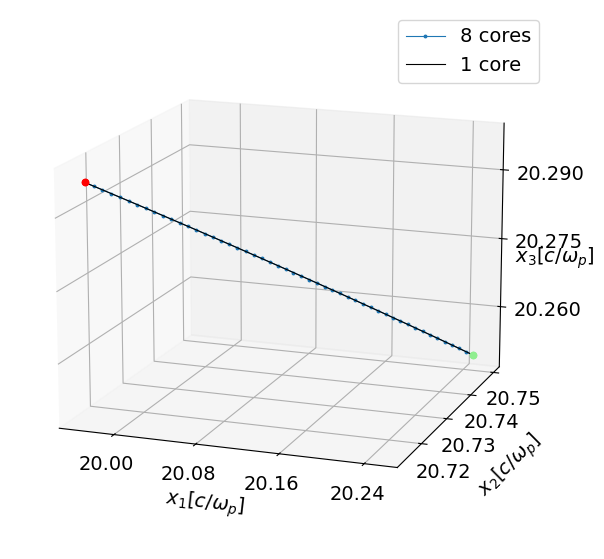

In [34]:
particle = 10

# 3D Trajectory
fig, ax = None, None

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_1core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_8cores/Gca.in")

core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_1coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_8coresBoris/Boris.in")

core1GcaCorr = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_1coreGcaCorr/Gca.in")
core8GcaCorr = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_8coresgcaCorr/Gca.in")
tmax=307.8760659

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core8, fr"8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1, fr"1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


In [35]:
Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

Track8Boris = core8Boris["test_electrons"]["tracks"]
Track1Boris = core1Boris["test_electrons"]["tracks"]

Track8GcaCorr = core8GcaCorr["test_electrons"]["tracks"]
Track1GcaCorr = core1GcaCorr["test_electrons"]["tracks"]

print(Track8["t"][998,25:30])
print(Track8["p3"][998,25:30])
print(Track1["p3"][998,25:30])

[157.079625 163.36281  169.645995 175.92918  182.212365]
[-1.65951757e-05 -1.65851124e-05 -1.65750372e-05 -1.65649500e-05
 -1.65548510e-05]
[-1.65951757e-05 -1.65851124e-05 -1.65750372e-05 -1.65649500e-05
 -1.65548510e-05]


24.88941891; 24.69969774; 24.72458018

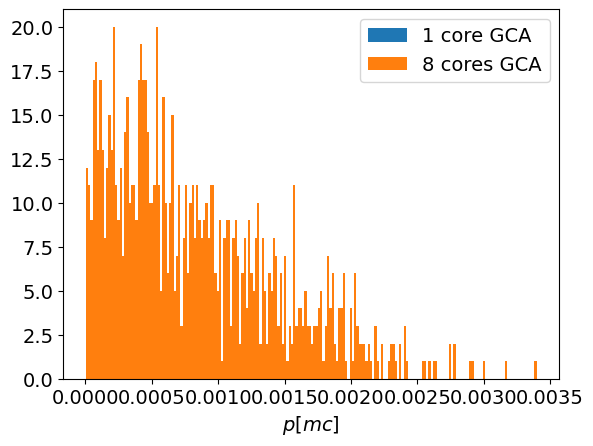

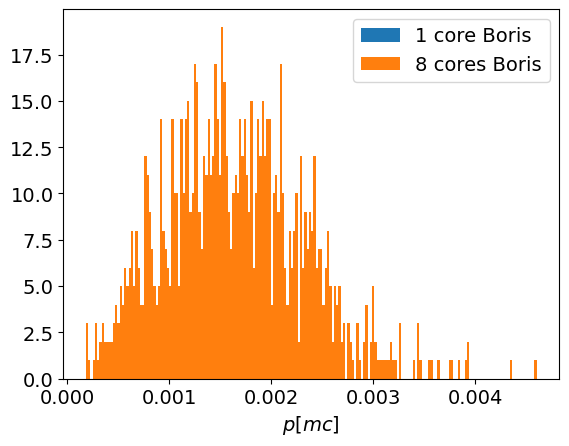

In [36]:
# Understand velocity of gyrocenter
def plot_hist(track, t=-1, fig=None, ax=None, label=""):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    # label = ("$t = {:.2f}$".format(track["t"][0, t]) + "$[{}]$".format(track.units["t"]))

    p = np.sqrt(track["p1"][:,t]**2 + track["p2"][:,t]**2 + track["p3"][:,t]**2)
    ax.hist(p, bins=200, label=label)
    ax.set_xlabel("$p$" + "$[{}]$".format(track.units["p3"]))

    plt.legend()

    return fig, ax

fig, ax = None, None
fig, ax = plot_hist(Track1, fig=fig, ax=ax, label="1 core GCA")
fig, ax = plot_hist(Track8, fig=fig, ax=ax, label="8 cores GCA")
plt.show()

fig, ax = None, None
fig, ax = plot_hist(Track1Boris, fig=fig, ax=ax, label="1 core Boris")
fig, ax = plot_hist(Track8Boris, fig=fig, ax=ax, label="8 cores Boris")
plt.show()

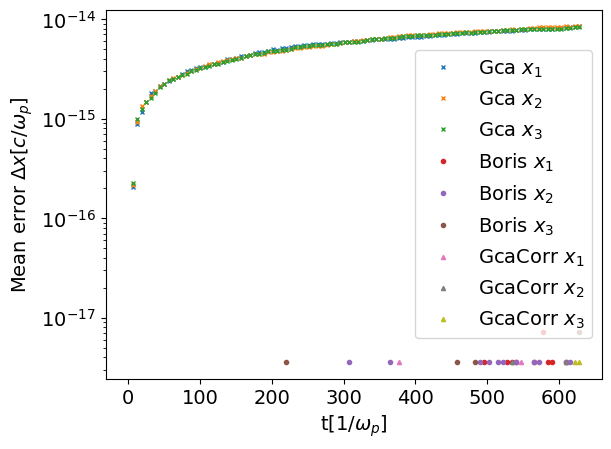

In [37]:
t = Track1["t"][0,:]

errx1 = np.abs(Track1["x1"][:,:] - Track8["x1"][:,:]).mean(axis=0)
errx2 = np.abs(Track1["x2"][:,:] - Track8["x2"][:,:]).mean(axis=0)
errx3 = np.abs(Track1["x3"][:,:] - Track8["x3"][:,:]).mean(axis=0)

errx1Boris = np.abs(Track1Boris["x1"][:,:] - Track8Boris["x1"][:,:]).mean(axis=0)
errx2Boris = np.abs(Track1Boris["x2"][:,:] - Track8Boris["x2"][:,:]).mean(axis=0)
errx3Boris = np.abs(Track1Boris["x3"][:,:] - Track8Boris["x3"][:,:]).mean(axis=0)

errx1GcaCorr = np.abs(Track1GcaCorr["x1"][:,:] - Track8GcaCorr["x1"][:,:]).mean(axis=0)
errx2GcaCorr = np.abs(Track1GcaCorr["x2"][:,:] - Track8GcaCorr["x2"][:,:]).mean(axis=0)
errx3GcaCorr = np.abs(Track1GcaCorr["x3"][:,:] - Track8GcaCorr["x3"][:,:]).mean(axis=0)

fig, ax = plt.subplots()
ax.plot(t, errx1, label="Gca $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx2, label="Gca $x_2$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx3, label="Gca $x_3$", linewidth=0, marker='x', markersize=3)

ax.plot(t, errx1Boris, label="Boris $x_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errx2Boris, label="Boris $x_2$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errx3Boris, label="Boris $x_3$", linewidth=0, marker='o', markersize=3)

ax.plot(t, errx1GcaCorr, label="GcaCorr $x_1$", linewidth=0, marker='^', markersize=3)
ax.plot(t, errx2GcaCorr, label="GcaCorr $x_2$", linewidth=0, marker='^', markersize=3)
ax.plot(t, errx3GcaCorr, label="GcaCorr $x_3$", linewidth=0, marker='^', markersize=3)

ax.set_ylabel(r"Mean error $\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
plt.show()


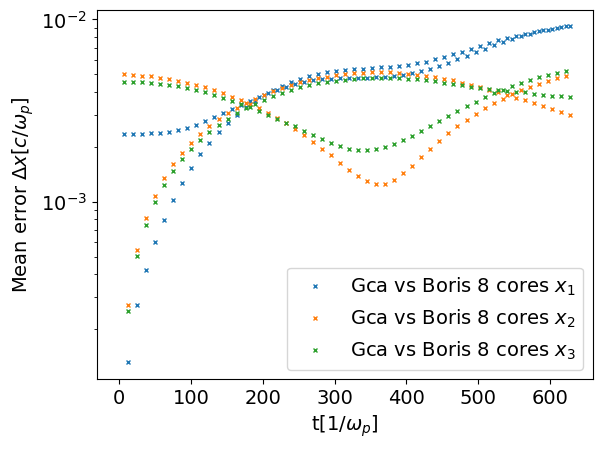

In [38]:
errx1 = np.abs(Track8Boris["x1"][:,:] - Track8["x1"][:,:]).mean(axis=0)
errx2 = np.abs(Track8Boris["x2"][:,:] - Track8["x2"][:,:]).mean(axis=0)
errx3 = np.abs(Track8Boris["x3"][:,:] - Track8["x3"][:,:]).mean(axis=0)

fig, ax = plt.subplots()
ax.plot(t, errx1, label="Gca vs Boris 8 cores $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx2, label="Gca vs Boris 8 cores $x_2$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx3, label="Gca vs Boris 8 cores $x_3$", linewidth=0, marker='x', markersize=3)


ax.set_ylabel(r"Mean error $\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
plt.show()

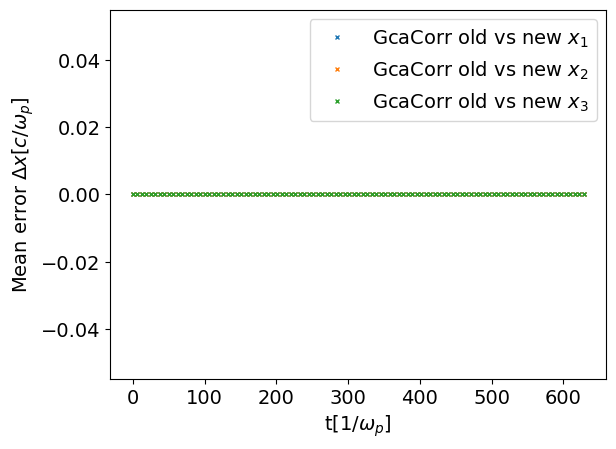

In [39]:
GcaCorrOld = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_1coreGcaCorr/Gca.in")

GcaCorrNew = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_1coreGcaCorr_test/Gca.in")
Trackold = GcaCorrOld["test_electrons"]["tracks"]
Tracknew = GcaCorrNew["test_electrons"]["tracks"]
t = Trackold["t"][0,:]

errx1 = np.abs(Trackold["x1"][:,:] - Tracknew["x1"][:,:]).mean(axis=0)
errx2 = np.abs(Trackold["x2"][:,:] - Tracknew["x2"][:,:]).mean(axis=0)
errx3 = np.abs(Trackold["x3"][:,:] - Tracknew["x3"][:,:]).mean(axis=0)

fig, ax = plt.subplots()
ax.plot(t, errx1, label="GcaCorr old vs new $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx2, label="GcaCorr old vs new $x_2$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx3, label="GcaCorr old vs new $x_3$", linewidth=0, marker='x', markersize=3)


ax.set_ylabel(r"Mean error $\Delta x$" + "$[{}]$".format(Trackold.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Trackold.units["t"]))
ax.legend()
plt.show()

## GradB


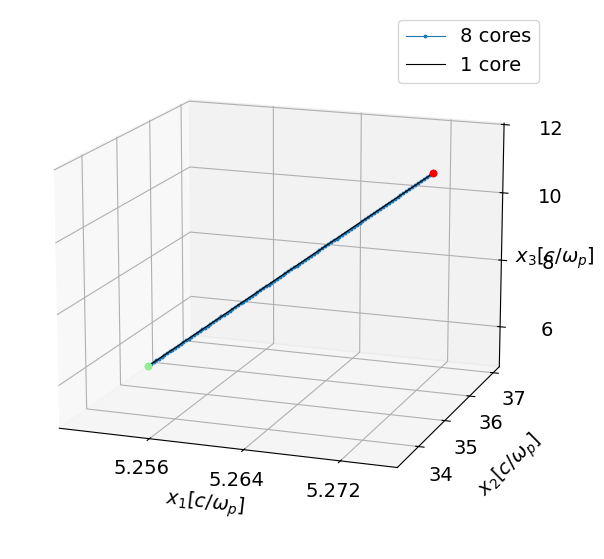

In [40]:
particle = 0

# 3D Trajectory
fig, ax = None, None

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/gradB/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/gradB/dtw100_8_cores/Gca.in")
tmax=99999999999999999999999

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core8, fr"8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1, fr"1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


## Curv

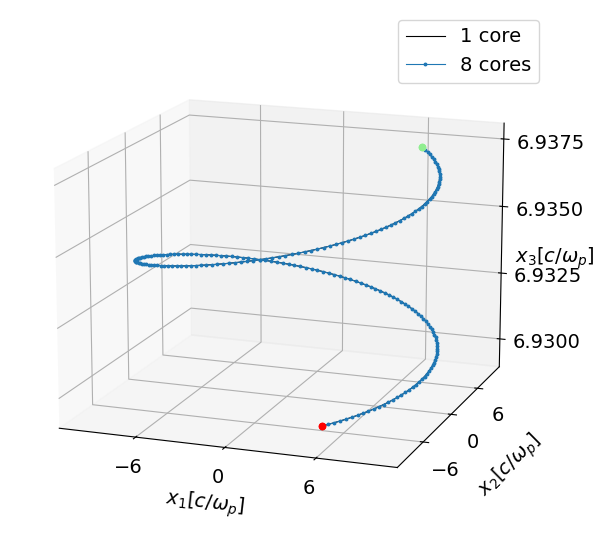

In [41]:
particle = 0

# 3D Trajectory
fig, ax = None, None

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_8_cores/Gca.in")

core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_8_coresBoris/Boris.in")

tmax=99999999999999999999999

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core1, fr"1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)
fig, ax = plot_trajectory(core8, fr"8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


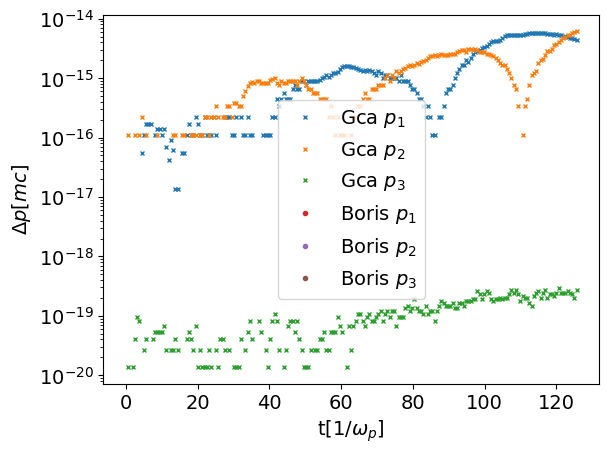

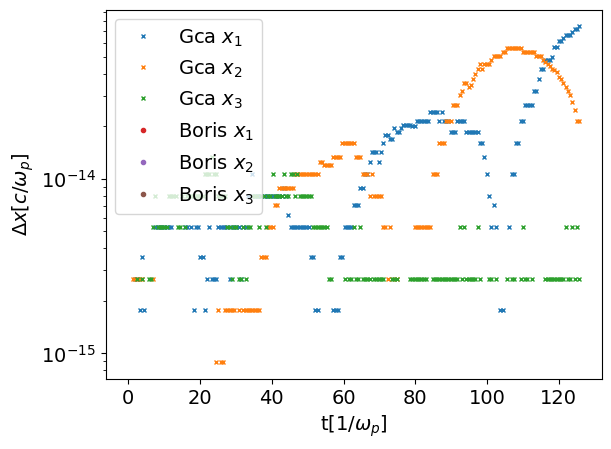

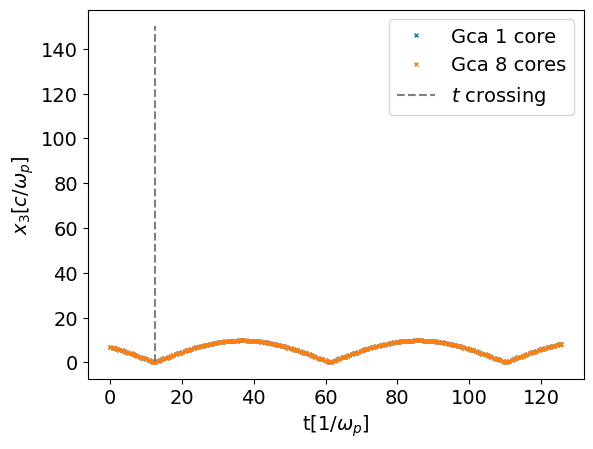

In [42]:
idx=0

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_8_cores/Gca.in")

core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_8_coresBoris/Boris.in")

Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

Track1Boris = core1Boris["test_electrons"]["tracks"]
Track8Boris = core8Boris["test_electrons"]["tracks"]

t = Track1["t"][0,:]



errp1 = np.abs(Track1["p1"][0,:] - Track8["p1"][0,:])
errp2 = np.abs(Track1["p2"][0,:] - Track8["p2"][0,:])
errp3 = np.abs(Track1["p3"][0,:] - Track8["p3"][0,:])

errp1Boris = np.abs(Track1Boris["p1"][0,:] - Track8Boris["p1"][0,:])
errp2Boris = np.abs(Track1Boris["p2"][0,:] - Track8Boris["p2"][0,:])
errp3Boris = np.abs(Track1Boris["p3"][0,:] - Track8Boris["p3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, errp1, label="Gca $p_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp2, label="Gca $p_2$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp3, label="Gca $p_3$", linewidth=0, marker='x', markersize=3)

ax.plot(t, errp1Boris, label="Boris $p_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp2Boris, label="Boris $p_2$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp3Boris, label="Boris $p_3$", linewidth=0, marker='o', markersize=3)

ax.set_ylabel(r"$\Delta p$" + "$[{}]$".format(Track1.units["p3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
plt.show()






errp1 = np.abs(Track1["x1"][0,:] - Track8["x1"][0,:])
errp2 = np.abs(Track1["x2"][0,:] - Track8["x2"][0,:])
errp3 = np.abs(Track1["x3"][0,:] - Track8["x3"][0,:])

errp1Boris = np.abs(Track1Boris["x1"][0,:] - Track8Boris["x1"][0,:])
errp2Boris = np.abs(Track1Boris["x2"][0,:] - Track8Boris["x2"][0,:])
errp3Boris = np.abs(Track1Boris["x3"][0,:] - Track8Boris["x3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, errp1, label="Gca $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp2, label="Gca $x_2$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp3, label="Gca $x_3$", linewidth=0, marker='x', markersize=3)

ax.plot(t, errp1Boris, label="Boris $x_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp2Boris, label="Boris $x_2$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp3Boris, label="Boris $x_3$", linewidth=0, marker='o', markersize=3)

ax.set_ylabel(r"$\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
plt.show()




errp1 = np.abs(Track1["x1"][0,:] - Track8["x1"][0,:])
errp2 = np.abs(Track1["x2"][0,:] - Track8["x2"][0,:])
errp3 = np.abs(Track1["x3"][0,:] - Track8["x3"][0,:])

errp1Boris = np.abs(Track1Boris["x1"][0,:] - Track8Boris["x1"][0,:])
errp2Boris = np.abs(Track1Boris["x2"][0,:] - Track8Boris["x2"][0,:])
errp3Boris = np.abs(Track1Boris["x3"][0,:] - Track8Boris["x3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, np.abs(Track1["x2"][0,:]), label="Gca 1 core", linewidth=0, marker='x', markersize=3)
ax.plot(t, np.abs(Track8["x2"][0,:]), label="Gca 8 cores", linewidth=0, marker='x', markersize=3)
# ax.plot(t, np.abs(Track1Boris["x3"][0,:]), label="Boris 1 core", linewidth=0, marker='o', markersize=3)
# ax.plot(t, np.abs(Track8Boris["x3"][0,:]), label="Boris 8 cores", linewidth=0, marker='o', markersize=3)

ax.set_ylabel(r"$x_3$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))

ax.vlines(t[20], ymin=0, ymax=150, colors='gray', linestyles='dashed', label=r"$t$ crossing")
ax.legend()
plt.show()

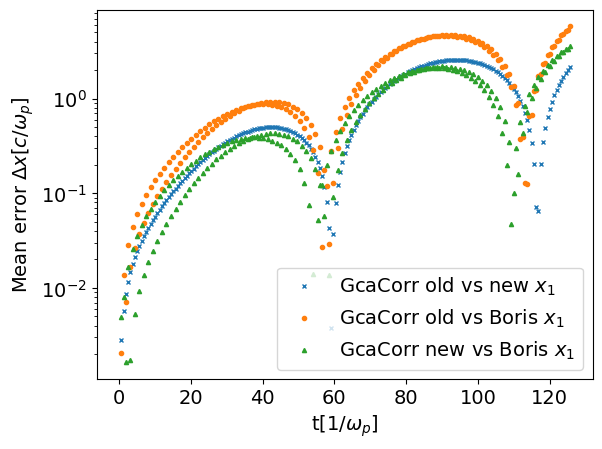

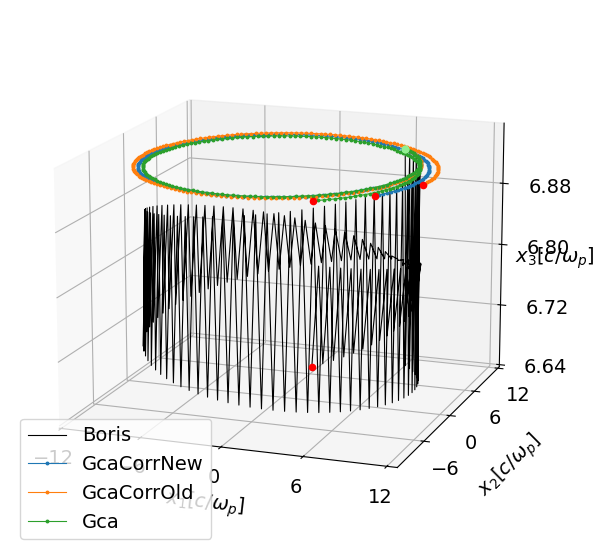

In [53]:
GcaCorrOld = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_coreGcaCorr/Gca.in")

Gca = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_core/Gca.in")

GcaCorrNew =ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_coreGcaCorr_test/Gca.in")

Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curv/dtw100_1_coreBoris/Boris.in")

TrackBoris = Boris["test_electrons"]["tracks"]
Trackold = GcaCorrOld["test_electrons"]["tracks"]
Tracknew = GcaCorrNew["test_electrons"]["tracks"]
TrackGca = Gca["test_electrons"]["tracks"]
t = Trackold["t"][0,:]

errx1 = np.abs(Trackold["x1"][:,:] - Tracknew["x1"][:,:]).mean(axis=0)
errx2 = np.abs(Trackold["x2"][:,:] - Tracknew["x2"][:,:]).mean(axis=0)
errx3 = np.abs(Trackold["x3"][:,:] - Tracknew["x3"][:,:]).mean(axis=0)

errx1Gca = np.abs(TrackGca["x1"][:,:] - Trackold["x1"][:,:]).mean(axis=0)
errx2Gca = np.abs(TrackGca["x2"][:,:] - Trackold["x2"][:,:]).mean(axis=0)
errx3Gca = np.abs(TrackGca["x3"][:,:] - Trackold["x3"][:,:]).mean(axis=0)

errx1Boris = np.abs(TrackBoris["x1"][:,:] - Trackold["x1"][:,:]).mean(axis=0)
errx2Boris = np.abs(TrackBoris["x2"][:,:] - Trackold["x2"][:,:]).mean(axis=0)
errx3Boris = np.abs(TrackBoris["x3"][:,:] - Trackold["x3"][:,:]).mean(axis=0)

errx1NewBoris = np.abs(TrackBoris["x1"][:,:] - Tracknew["x1"][:,:]).mean(axis=0)
errx2NewBoris = np.abs(TrackBoris["x2"][:,:] - Tracknew["x2"][:,:]).mean(axis=0)
errx3NewBoris = np.abs(TrackBoris["x3"][:,:] - Tracknew["x3"][:,:]).mean(axis=0)

fig, ax = plt.subplots()
ax.plot(t, errx1, label="GcaCorr old vs new $x_1$", linewidth=0, marker='x', markersize=3)
# ax.plot(t, errx2, label="GcaCorr old vs new $x_2$", linewidth=0, marker='x', markersize=3)
# ax.plot(t, errx3, label="GcaCorr old vs new $x_3$", linewidth=0, marker='x', markersize=3)

# ax.plot(t, errx1, label="GcaCorr old vs GCA $x_1$", linewidth=0, marker='x', markersize=3)
# ax.plot(t, errx2, label="GcaCorr old vs GCA $x_2$", linewidth=0, marker='x', markersize=3)
# ax.plot(t, errx3, label="GcaCorr old vs GCA $x_3$", linewidth=0, marker='x', markersize=3)

ax.plot(t, errx1Boris, label="GcaCorr old vs Boris $x_1$", linewidth=0, marker='o', markersize=3)
# ax.plot(t, errx2Boris, label="GcaCorr old vs Boris $x_2$", linewidth=0, marker='o', markersize=3)
# ax.plot(t, errx3Boris, label="GcaCorr old vs Boris $x_3$", linewidth=0, marker='o', markersize=3)

ax.plot(t, errx1NewBoris, label="GcaCorr new vs Boris $x_1$", linewidth=0, marker='^', markersize=3)
# ax.plot(t, errx2NewBoris, label="GcaCorr new vs Boris $x_2$", linewidth=0, marker='^', markersize=3)
# ax.plot(t, errx3NewBoris, label="GcaCorr new vs Boris $x_3$", linewidth=0, marker='^', markersize=3)

ax.set_ylabel(r"Mean error $\Delta x$" + "$[{}]$".format(Trackold.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Trackold.units["t"]))
ax.set_yscale('log')
ax.legend()
plt.show()






tmax=99999999999999999999999

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")
fig, ax = None, None
fig, ax = plot_trajectory(Boris, fr"Boris", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)
fig, ax = plot_trajectory(GcaCorrNew, fr"GcaCorrNew", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(GcaCorrOld, fr"GcaCorrOld", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(Gca, fr"Gca", particle=particle, tmax=tmax, fig=fig, ax=ax)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()

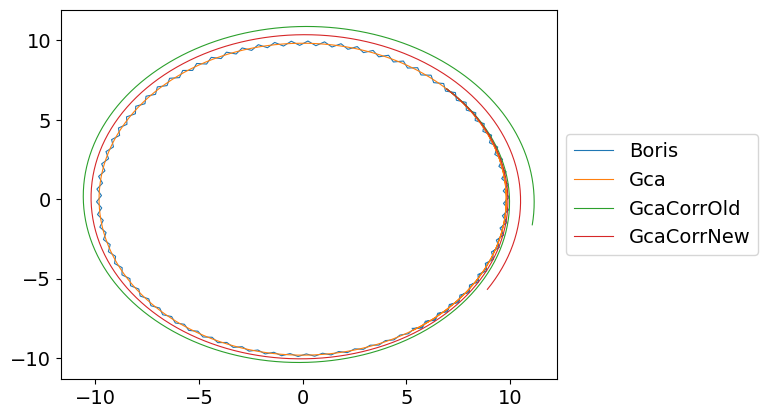

In [54]:
fig, ax = plt.subplots()

ax.plot(Boris["test_electrons"]["tracks"]["x1"][particle,:], 
                Boris["test_electrons"]["tracks"]["x2"][particle,:], 
                label = "Boris", 
                marker='o', linestyle='-', markersize=0, linewidth=0.8)
ax.plot(Gca["test_electrons"]["tracks"]["x1"][particle,:], 
                Gca["test_electrons"]["tracks"]["x2"][particle,:], 
                label = "Gca", 
                marker='s', linestyle='-', markersize=0, linewidth=0.8)
ax.plot(GcaCorrOld["test_electrons"]["tracks"]["x1"][particle,:], 
                GcaCorrOld["test_electrons"]["tracks"]["x2"][particle,:], 
                label = "GcaCorrOld", 
                marker='x', linestyle='-', markersize=0, linewidth=0.8)
ax.plot(GcaCorrNew["test_electrons"]["tracks"]["x1"][particle,:], 
                GcaCorrNew["test_electrons"]["tracks"]["x2"][particle,:], 
                label = "GcaCorrNew", 
                marker='^', linestyle='-', markersize=0, linewidth=0.8)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Weibel L400 Hot

In [ ]:
particle = 490

# 3D Trajectory
fig, ax = None, None

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_L400Hot_1core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/weibel/dtw10_L400Hot_8cores/Gca.in")
tmax=307.8760659

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core8, fr"8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1, fr"1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


In [ ]:
Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

fig, ax = None, None
fig, ax = plot_hist(Track1, t=-1, fig=fig, ax=ax)
fig, ax = plot_hist(Track8, t=-1, fig=fig, ax=ax)

In [ ]:
np.argmax(np.abs(Track1["p1"][:,-1]-Track8["p1"][:,-1]))

In [ ]:
print(Track1[:][490,-1])
print(Track8[:][490,-1])

## Uniform B . test periodic bounds


In [ ]:
idx=0

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/periodic/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/periodic/dtw100_8_cores/Gca.in")

# Boris was not run with the 2 extra ghost cells
core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/periodic/dtw100_1_coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/periodic/dtw100_8_coresBoris/Boris.in")

core8Boris2GC = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/periodic/dtw100_8_coresBoris_2GC/Boris.in")

Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

Track1Boris = core1Boris["test_electrons"]["tracks"]
Track8Boris = core8Boris["test_electrons"]["tracks"]
Track8Boris2GC = core8Boris2GC["test_electrons"]["tracks"]

t = Track1["t"][0,:]



fig, ax = plt.subplots()
ax.plot(t, Track1["x1"][0,:], label="Gca 1 core", linewidth=4, linestyle="-", marker='x', markersize=0)
ax.plot(t, Track8["x1"][0,:], label="Gca 8 cores", linewidth=4, linestyle="--", marker='x', markersize=0)
ax.plot(t, Track8Boris["x1"][0,:], label="Boris 8 cores", linewidth=4, linestyle="-.", marker='o', markersize=0)
ax.plot(t, Track8Boris2GC["x1"][0,:], label="Boris 8 cores 2GC", linewidth=4, linestyle=":", marker='^', markersize=0)
ax.plot(t, Track1Boris["x1"][0,:], label="Boris 1 core", linewidth=1, linestyle="-", marker='o', markersize=0, color="black")

ax.set_ylabel(r"$x_1$" + "$[{}]$".format(Track1.units["x1"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.grid()

ax.legend()
plt.show()




errp1 = np.abs(Track1["x1"][0,:] - Track8["x1"][0,:])
errp2 = np.abs(Track1["x2"][0,:] - Track8["x2"][0,:])
errp3 = np.abs(Track1["x3"][0,:] - Track8["x3"][0,:])

errp1Boris = np.abs(Track1Boris["x1"][0,:] - Track8Boris["x1"][0,:])
errp2Boris = np.abs(Track1Boris["x2"][0,:] - Track8Boris["x2"][0,:])
errp3Boris = np.abs(Track1Boris["x3"][0,:] - Track8Boris["x3"][0,:])

errp1Boris2GC = np.abs(Track1Boris["x1"][0,:] - Track8Boris2GC["x1"][0,:])
errp2Boris2GC = np.abs(Track1Boris["x2"][0,:] - Track8Boris2GC["x2"][0,:])
errp3Boris2GC = np.abs(Track1Boris["x3"][0,:] - Track8Boris2GC["x3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, errp1, label="Gca $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp1Boris, label="Boris $x_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp1Boris2GC, label="Boris 2GC $x_1$", linewidth=0, marker='^', markersize=3)

ax.set_ylabel(r"$\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
ax.grid()
plt.show()


## Uniform B - reflecting boundaries

In [ ]:
idx=0

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting/dtw100_8_cores/Gca.in")

# Boris was not run with the 2 extra ghost cells
core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting/dtw100_1_coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting/dtw100_8_coresBoris/Boris.in")

core8Boris2GC = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting/dtw100_8_coresBoris_2GC/Boris.in")

Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

Track1Boris = core1Boris["test_electrons"]["tracks"]
Track8Boris = core8Boris["test_electrons"]["tracks"]
Track8Boris2GC = core8Boris2GC["test_electrons"]["tracks"]

t = Track1["t"][0,:]



fig, ax = plt.subplots()
ax.plot(t, Track1["x1"][0,:], label="Gca 1 core", linewidth=4, linestyle="-", marker='x', markersize=0)
ax.plot(t, Track8["x1"][0,:], label="Gca 8 cores", linewidth=4, linestyle="--", marker='x', markersize=0)
ax.plot(t, Track8Boris["x1"][0,:], label="Boris 8 cores", linewidth=4, linestyle="-.", marker='o', markersize=0)
ax.plot(t, Track8Boris2GC["x1"][0,:], label="Boris 8 cores 2GC", linewidth=4, linestyle=":", marker='^', markersize=0)
ax.plot(t, Track1Boris["x1"][0,:], label="Boris 1 core", linewidth=1, linestyle="-", marker='o', markersize=0, color="black")

ax.set_ylabel(r"$x_1$" + "$[{}]$".format(Track1.units["x1"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))

ax.legend()
ax.grid()
plt.show()




errp1 = np.abs(Track1["x1"][0,:] - Track8["x1"][0,:])
errp2 = np.abs(Track1["x2"][0,:] - Track8["x2"][0,:])
errp3 = np.abs(Track1["x3"][0,:] - Track8["x3"][0,:])

errp1Boris = np.abs(Track1Boris["x1"][0,:] - Track8Boris["x1"][0,:])
errp2Boris = np.abs(Track1Boris["x2"][0,:] - Track8Boris["x2"][0,:])
errp3Boris = np.abs(Track1Boris["x3"][0,:] - Track8Boris["x3"][0,:])

errp1Boris2GC = np.abs(Track1Boris["x1"][0,:] - Track8Boris2GC["x1"][0,:])
errp2Boris2GC = np.abs(Track1Boris["x2"][0,:] - Track8Boris2GC["x2"][0,:])
errp3Boris2GC = np.abs(Track1Boris["x3"][0,:] - Track8Boris2GC["x3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, errp1, label="Gca $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp1Boris, label="Boris $x_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp1Boris2GC, label="Boris 2GC $x_1$", linewidth=0, marker='^', markersize=3)

ax.set_ylabel(r"$\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
ax.grid()
plt.show()


## Uniform B - open boundaries

In [ ]:
idx=0

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/open/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/open/dtw100_8_cores/Gca.in")

# Boris was not run with the 2 extra ghost cells
core1Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/open/dtw100_1_coreBoris/Boris.in")
core8Boris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/open/dtw100_8_coresBoris/Boris.in")

core8Boris2GC = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/open/dtw100_8_coresBoris_2GC/Boris.in")

Track8 = core8["test_electrons"]["tracks"]
Track1 = core1["test_electrons"]["tracks"]

Track1Boris = core1Boris["test_electrons"]["tracks"]
Track8Boris = core8Boris["test_electrons"]["tracks"]
Track8Boris2GC = core8Boris2GC["test_electrons"]["tracks"]

t = Track1["t"][0,:]



fig, ax = plt.subplots()
ax.plot(t, Track1["x1"][0,:], label="Gca 1 core", linewidth=4, linestyle="-", marker='x', markersize=0)
ax.plot(t, Track8["x1"][0,:], label="Gca 8 cores", linewidth=4, linestyle="--", marker='x', markersize=0)
ax.plot(t, Track8Boris["x1"][0,:], label="Boris 8 cores", linewidth=4, linestyle="-.", marker='o', markersize=0)
ax.plot(t, Track8Boris2GC["x1"][0,:], label="Boris 8 cores 2GC", linewidth=4, linestyle=":", marker='^', markersize=0)
ax.plot(t, Track1Boris["x1"][0,:], label="Boris 1 core", linewidth=1, linestyle="-", marker='o', markersize=0, color="black")

ax.set_ylabel(r"$x_1$" + "$[{}]$".format(Track1.units["x1"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))

ax.legend()
ax.grid()
plt.show()




errp1 = np.abs(Track1["x1"][0,:] - Track8["x1"][0,:])
errp2 = np.abs(Track1["x2"][0,:] - Track8["x2"][0,:])
errp3 = np.abs(Track1["x3"][0,:] - Track8["x3"][0,:])

errp1Boris = np.abs(Track1Boris["x1"][0,:] - Track8Boris["x1"][0,:])
errp2Boris = np.abs(Track1Boris["x2"][0,:] - Track8Boris["x2"][0,:])
errp3Boris = np.abs(Track1Boris["x3"][0,:] - Track8Boris["x3"][0,:])

errp1Boris2GC = np.abs(Track1Boris["x1"][0,:] - Track8Boris2GC["x1"][0,:])
errp2Boris2GC = np.abs(Track1Boris["x2"][0,:] - Track8Boris2GC["x2"][0,:])
errp3Boris2GC = np.abs(Track1Boris["x3"][0,:] - Track8Boris2GC["x3"][0,:])

fig, ax = plt.subplots()
ax.plot(t, errp1, label="Gca $x_1$", linewidth=0, marker='x', markersize=3)
ax.plot(t, errp1Boris, label="Boris $x_1$", linewidth=0, marker='o', markersize=3)
ax.plot(t, errp1Boris2GC, label="Boris 2GC $x_1$", linewidth=0, marker='^', markersize=3)

ax.set_ylabel(r"$\Delta x$" + "$[{}]$".format(Track1.units["x3"]))
ax.set_xlabel("t"+ "$[{}]$".format(Track1.units["t"]))
ax.legend()
ax.set_yscale('log')
ax.grid()
plt.show()


## EM wave -- emf bound reflective

In [ ]:
original = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting_emf/dtw100_8_coresBoris/Boris.in")
extraGC = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/testBounds/reflecting_emf/dtw100_8_cores/Gca.in")

fig, ax = plt.subplots()
for t in range(0, 20, 1):
    data = original["part_e2"][t][:,20,20]
    ax.plot(original["part_e2"].x[0], data, marker='o', linestyle='', markersize=1)
plt.show()

fig, ax = plt.subplots()
for t in range(0, 20, 1):
    data = extraGC["part_e2"][t][:,20,20]
    ax.plot(original["part_e2"].x[0], data, marker='o', linestyle='', markersize=1)
plt.show()

## Test if gcaCorr parallel is good

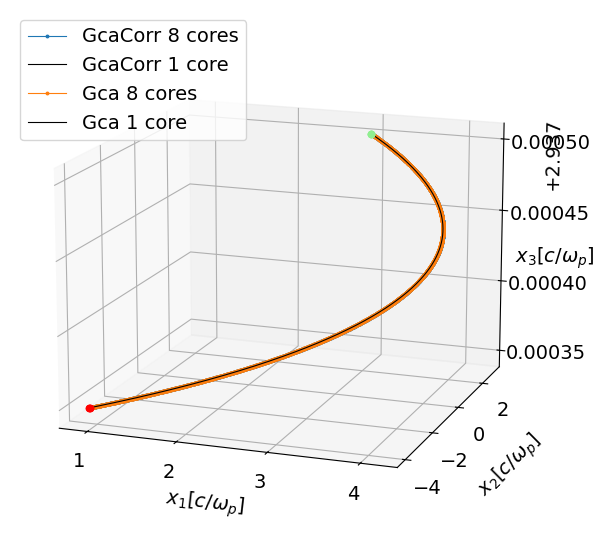

In [69]:
particle = 0

# 3D Trajectory
fig, ax = None, None

core1GcaCorr = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGcaCorr/dtw100_1_core/GcaCorr.in")
core8GcaCorr = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGcaCorr/dtw100_8_cores/GcaCorr.in")
core1GcaCorrRefactored = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGcaCorrRefactored/dtw100_1_core/GcaCorr.in")
core8GcaCorrRefactored = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGcaCorrRefactored/dtw100_8_cores/GcaCorr.in")
core1Gca = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGca/dtw100_1_core/Gca.in")
core8Gca = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGca/dtw100_8_cores/Gca.in")
tmax=307.8760659

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core8GcaCorr, fr"GcaCorr 8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1GcaCorr, fr"GcaCorr 1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)
fig, ax = plot_trajectory(core8Gca, fr"Gca 8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1Gca, fr"Gca 1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


## Test refactoring

[]

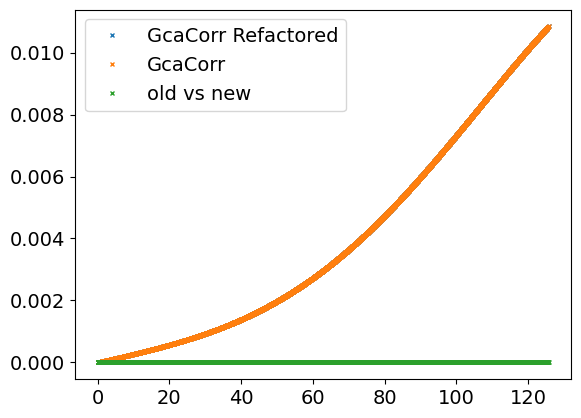

In [72]:

Trackcore1GcaCorrRefactored = core1GcaCorrRefactored["test_electrons"]["tracks"]
Trackcore8GcaCorrRefactored = core8GcaCorrRefactored["test_electrons"]["tracks"]
Trackcore1GcaCorr = core1GcaCorr["test_electrons"]["tracks"]
Trackcore8GcaCorr = core8GcaCorr["test_electrons"]["tracks"]
Trackcore1Gca = core1Gca["test_electrons"]["tracks"]

t = Trackcore1GcaCorrRefactored["t"][0,:]

errx1 = np.abs(Trackcore1GcaCorrRefactored["x1"][:,:] - Trackcore1Gca["x1"][:,:]).mean(axis=0)
errx2 = np.abs(Trackcore1GcaCorr["x1"][:,:] - Trackcore1Gca["x1"][:,:]).mean(axis=0)

errx3 = np.abs(Trackcore1GcaCorrRefactored["x1"][:,:] - Trackcore1GcaCorr["x1"][:,:]).mean(axis=0)


fig, ax = plt.subplots()
ax.plot(t, errx1, label="GcaCorr Refactored", linewidth=0, marker='x', markersize=3)
ax.plot(t, errx2, label="GcaCorr", linewidth=0, marker='x', markersize=3)

ax.plot(t, errx3, label="old vs new", linewidth=0, marker='x', markersize=3)

plt.legend()
plt.plot()

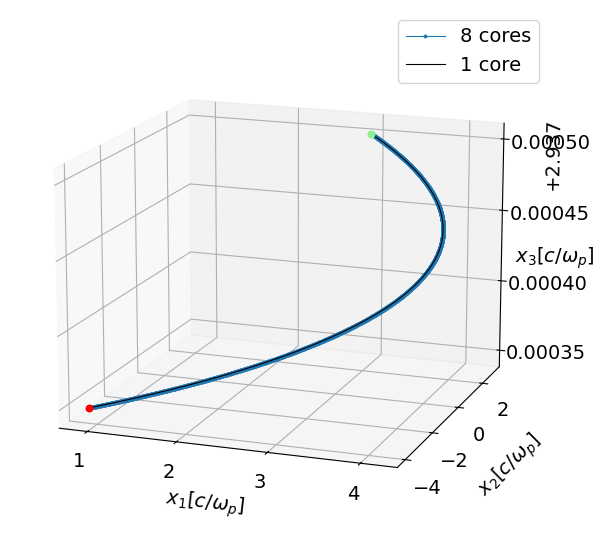

In [71]:
particle = 0

# 3D Trajectory
fig, ax = None, None

core1 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGca/dtw100_1_core/Gca.in")
core8 = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/curvGca/dtw100_8_cores/Gca.in")
tmax=307.8760659

# Boris1000short = ou.Simulation(f"/home/exxxx5/Tese/Decks/MethodicTests/{test}/Boris/dtw1000short/Boris.in")

fig, ax = plot_trajectory(core8, fr"8 cores", particle=particle, tmax=tmax, fig=fig, ax=ax)
fig, ax = plot_trajectory(core1, fr"1 core", particle=particle, tmax=tmax, fig=fig, ax=ax, color="black", markersize=0)


ax.view_init(elev=15, azim=-70)
# ax.tick_params(axis='x', pad=15)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='z', pad=15)

ax.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.zaxis.set_major_locator(plt.MaxNLocator(4))



# ax.set_xlim(-15, 15) 
# ax.set_ylim(-15, 15)
# ax.set_zlim(6.4, 6.6)

ax.zaxis.set_rotate_label(False)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 3 

ax.set_zlabel("")
# add a manual label in axes (2D) coords: (x,y) in [0,1]
ax.text2D(1.01, 0.54, r"$x_3[c/\omega_p]$", transform=ax.transAxes,
          rotation=0, va="center", ha="center")
plt.show()


[]

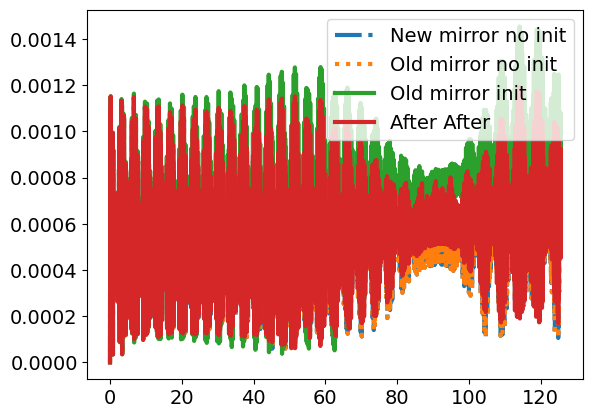

In [32]:
MirrorRelGcaCorr = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorr/GcaCorr.in")
MirrorRelGcaCorrAfter = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrAfter/MirrorRelGcaCorrAfter.in")
MirrorRelGcaCorrAfterAfter = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrAfterAfter/MirrorRelGcaCorrAfterAfter.in")
MirrorRelGcaCorrBefore = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrBefore/MirrorRelGcaCorrBefore.in")
MirrorRelGcaCorrNewMirrorNoInit = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrNewMirrorNoInit/MirrorRelGcaCorrNewMirrorNoInit.in")
MirrorRelGcaCorrOldMirrorNoInit = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrOldMirrorNoInit/MirrorRelGcaCorrOldMirrorNoInit.in")
MirrorRelGcaCorrOldMirrorInit = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelGcaCorrOldMirrorInit/MirrorRelGcaCorrOldMirrorInit.in")
MirrorRelBaselineBoris = ou.Simulation(f"/home/exxxx5/Tese/Decks/Paralelization/MirrorRelBaseline/Boris.in")



TrackMirrorRelGcaCorr = MirrorRelGcaCorr["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrAfter = MirrorRelGcaCorrAfter["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrAfterAfter = MirrorRelGcaCorrAfterAfter["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrBefore = MirrorRelGcaCorrBefore["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrNewMirrorNoInit = MirrorRelGcaCorrNewMirrorNoInit["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrOldMirrorNoInit = MirrorRelGcaCorrOldMirrorNoInit["test_electrons"]["tracks"]
TrackMirrorRelGcaCorrOldMirrorInit = MirrorRelGcaCorrOldMirrorInit["test_electrons"]["tracks"]
TrackMirrorRelBaselineBoris = MirrorRelBaselineBoris["test_electrons"]["tracks"]

t = TrackMirrorRelGcaCorr["t"][0,:]

errx1 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrAfter["x1"][:,:]).mean(axis=0)
errx7 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrAfterAfter["x1"][:,:]).mean(axis=0)
errx2 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrBefore["x1"][:,:]).mean(axis=0)
errx3 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrNewMirrorNoInit["x1"][:,:]).mean(axis=0)
errx4 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrOldMirrorNoInit["x1"][:,:]).mean(axis=0)
errx6 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorrOldMirrorInit["x1"][:,:]).mean(axis=0)
errx5 = np.abs(TrackMirrorRelBaselineBoris["x1"][:,::10] - TrackMirrorRelGcaCorr["x1"][:,:]).mean(axis=0)


fig, ax = plt.subplots()
# ax.plot(t, errx5, label="Original", linewidth=3, linestyle='-', markersize=0)
# ax.plot(t, errx1, label="After", linewidth=3, linestyle='-', markersize=0)
# ax.plot(t, errx2, label="Before", linewidth=3, linestyle='--', markersize=0)
ax.plot(t, errx3, label="New mirror no init", linewidth=3, linestyle='-.', markersize=0)
ax.plot(t, errx4, label="Old mirror no init", linewidth=3, linestyle=':', markersize=0)
ax.plot(t, errx6, label="Old mirror init", linewidth=3, linestyle='-', markersize=0)
ax.plot(t, errx7, label="After After", linewidth=3, linestyle='-', markersize=0)
plt.legend()
plt.plot()